## **1.Importación de librerias y datos**
En este caso usaremos los datos limpios del precio nacional de cacao.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [48]:
# Cargar el archivo Excel
df = pd.read_excel("DatosAgroNet_limpio.xlsx")
df_total = df.copy()

train_size = int(len(df_total) * 0.8)
test_size = len(df_total) - train_size
df = df.iloc[:train_size]


# Mostrar las primeras filas
print(df.head())

       Fecha   COP/kg
0 2024-01-01  14271.7
1 2024-01-08  14223.3
2 2024-01-15  14086.3
3 2024-01-22  14329.2
4 2024-01-29  14530.8


## **3. Definir los parámetros**
`(p,d,q)` → parte no estacional

p: rezagos autorregresivos (cuántos valores pasados usa).  
d: diferencias necesarias para estacionarizar la serie.  
q: rezagos de errores pasados (parte MA).

`(P,D,Q,s)` → parte estacional

P: rezagos autorregresivos estacionales.  
D: diferencias estacionales necesarias (ej. 1 si la serie tiene ciclos anuales).  
Q: rezagos de errores pasados estacionales.  
s: longitud del ciclo → en datos semanales es 52 (1 año ≈ 52 semanas).

In [57]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

mejor_aic = float("inf")
mejores_parametros = None
mejor_modelo = None

p = d = q = range(0, 3)  # prueba valores de 0 a 2
P = D = Q = range(0, 2)  # valores típicos más bajos para estacionalidad
s = 52  # periodicidad estacional semanal anual

for i in p:
    for j in d:
        for k in q:
            for I in P:
                for J in D:
                    for K in Q:
                        try:
                            modelo = SARIMAX(df['COP/kg'],
                                            order=(i,j,k),
                                            seasonal_order=(I,J,K,s),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
                            resultado = modelo.fit(disp=False)
                            if resultado.aic < mejor_aic:
                                mejor_aic = resultado.aic
                                mejores_parametros = ((i,j,k), (I,J,K,s))
                                mejor_modelo = resultado
                        except:
                            continue

print(f'Mejor modelo SARIMA: orden no estacional {mejores_parametros[0]}, orden estacional {mejores_parametros[1]}, AIC: {mejor_aic}')


Mejor modelo SARIMA: orden no estacional (0, 0, 0), orden estacional (0, 1, 1, 52), AIC: 4.0


## **4. Aplicar el modelo a los datos**

In [ ]:
# Ajustar el modelo SARIMA (p,d,q) ( P,D,Q,s)
modelo = SARIMAX(df['COP/kg'], 
                 order=mejores_parametros[0], 
                 seasonal_order=mejores_parametros[1],
                 enforce_stationarity=False, 
                 enforce_invertibility=False)

resultado = modelo.fit()

print(resultado.summary())

                                 SARIMAX Results                                  
Dep. Variable:                     COP/kg   No. Observations:                   64
Model:             SARIMAX(0, 1, [1], 52)   Log Likelihood                   0.000
Date:                    Sat, 13 Sep 2025   AIC                              4.000
Time:                            15:17:55   BIC                                nan
Sample:                                 0   HQIC                               nan
                                     - 64                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52            0         -0        nan        nan           0           0
sigma2      3.761e+07         -0       -inf      0.000    3.76e+07    3.76e+07
Ljung-Box (L1) (Q): 

In [ ]:
# Hacer predicción para el próximo semestre (26 semanas)
prediccion = resultado.get_forecast(steps=test_size)

# Extraer predicción y intervalos de confianza
media_prediccion = prediccion.predicted_mean
intervalos_confianza = prediccion.conf_int()

64    26609.70
65    30037.70
66    32657.70
67    35032.80
68    36444.70
69    28363.83
70    28908.30
71    25158.30
72    28234.70
73    31491.70
74    34191.70
75    32950.70
76    28029.50
77    27896.50
78    29218.00
79    29380.80
80    30001.30
Name: predicted_mean, dtype: float64


In [64]:
# Calcular métricas de error
mae = mean_absolute_error(df_total['COP/kg'].iloc[-test_size:], media_prediccion)
rmse = np.sqrt(mean_squared_error(df_total['COP/kg'].iloc[-test_size:], media_prediccion))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 3958.7159
RMSE: 4541.9108


## **5. Graficar los resultados del forecast**

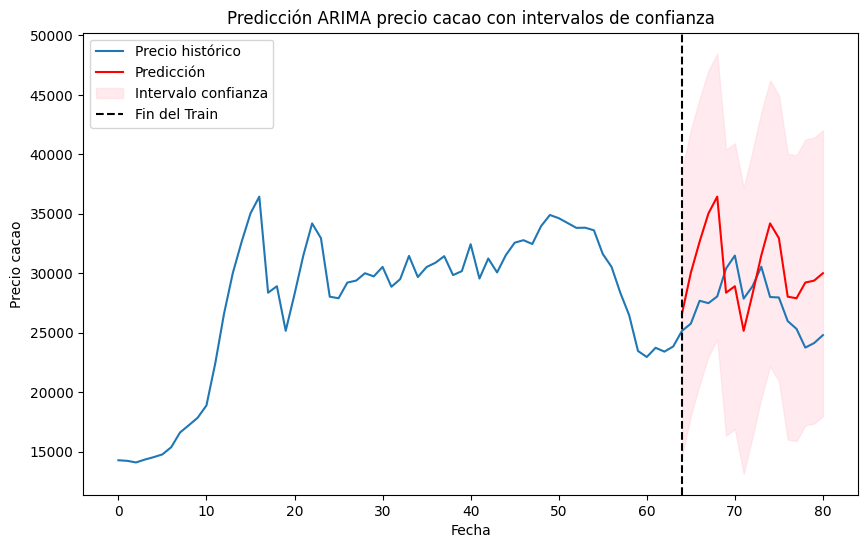

In [60]:
# Graficar datos históricos y predicción con intervalos de confianza
plt.figure(figsize=(10,6))
plt.plot(df_total.index, df_total['COP/kg'], label='Precio histórico')
plt.plot(media_prediccion.index, media_prediccion, color='red', label='Predicción')
plt.fill_between(intervalos_confianza.index, 
                 intervalos_confianza.iloc[:, 0], 
                 intervalos_confianza.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo confianza')
plt.axvline(df_total.index[train_size], color='k', linestyle='--', label='Fin del Train')

plt.xlabel('Fecha')
plt.ylabel('Precio cacao')
plt.title('Predicción ARIMA precio cacao con intervalos de confianza')
plt.legend()
plt.show()

El modelo logró capturar el alza de precios y refleja un posible escenario de continuidad de la tendencia alsista. Los intervalos de confianza amplios sugieren que el cacao es **altamente volátil**, y que el pronóstico sirve más como rango de posibles escenarios que como cifra exacta.